# LDA model on oncology

provider_type: surgical, hematology, gynecological, radiation, medical
- filter out least and most common hcpcs_codes (compared to model 1, which does no filtering)
- only consider in-facility claims
- number of topics = 13
- include all oncology specialties

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

from gensim import matutils, models, corpora

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [3]:
q = """SELECT npi, provider_type, hcpcs_code, hcpcs_description, bene_day_srvc_cnt
FROM payments WHERE provider_type LIKE '%Oncology' and place_of_service='F'"""
payments = pd.read_sql_query(q, con=con)

In [4]:
payments.shape

(92477, 5)

In [5]:
payments['provider_type'].unique()

array(['Hematology/Oncology', 'Medical Oncology', 'Surgical Oncology',
       'Radiation Oncology', 'Gynecological/Oncology'], dtype=object)

## read in processed dataframe (dropped top 10 codes, codes with only 1 claim, docs with < 1 claim)

In [6]:
by_npi = pd.read_csv("11d_by_npi_reduced_oncology_dataframe.csv", index_col=0)

In [7]:
by_npi.shape

(5067, 435)

## LDA on filtered data frame using 8 topics

In [9]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)

In [10]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [11]:
time0 = time.time()
ldamodel = models.ldamodel.LdaModel(corpus_tfidf, num_topics=8, passes=20)
print('calculated in {0}s'.format(time.time()-time0))

calculated in 70.24408340454102s


In [12]:
## Save model
ldamodel.save("11e_lda_8topics_colsDropped_docsDropped_oncology.model", pickle_protocol=3)

## Interpret the 8 topics in the model

In [13]:
## top 15 words in each topic
topics_matrix = ldamodel.show_topics(formatted=False, num_words=15)

In [14]:
## for each topic, store indices of top 20 hcpcs_codes in a list
topic_idx_dict = {}

for i in topics_matrix:
    topic_idx_dict[i[0]] = [int(word[0]) for word in i[1]]

In [15]:
## for each topic's list of indexes, get the list of hcpcs_codes
topic_dict = {}

for k, v in topic_idx_dict.items():
    topic_dict[k] = [by_npi.columns.values[i] for i in v]

In [16]:
## Topic 0
t = 0
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
28,77332,"Radiation treatment devices, design and constr..."
342,77328,Brachytherapy radiation therapy plan (over 10 ...
372,76873,Ultrasound of prostate
373,76965,Ultrasonic guidance for administration of radi...
386,77778,"Application of radiation source, complex"
387,77790,"Supervision, handling, loading of radiation"
833,55876,Insertion of radiation therapy devices in pros...
834,76942,Ultrasonic guidance imaging supervision and in...
1864,19081,Biopsy of breast accessed throught the skin wi...
4207,76950,Ultrasonic guidance for administration of radi...


In [17]:
## Topic 1
t = 1
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
17,77263,"Management of radiation therapy, complex"
18,77280,"Management of radiation therapy simulation, si..."
19,77290,"Management of radiation therapy, simulation, c..."
21,77295,"Management of radiation therapy, 3D"
22,77300,Calculation of radiation therapy dose
23,77301,Management of modulation radiotherapy planning
24,77315,"Isodose radiation therapy plan, complex"
27,77331,Special radiation therapy planning
28,77332,"Radiation treatment devices, design and constr..."
29,77334,"Radiation treatment devices, design and constr..."


In [18]:
## Topic 2
t = 2
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
10,38525,Biopsy or removal of lymph nodes of under the ...
11,38900,Lymph node imaging during surgery
444,76998,Ultrasonic guidance during surgery
508,92511,Examination of the nose and throat using an en...
771,48150,"Partial removal of pancreas, bile duct and sma..."
927,77786,"High dose brachytherapy delivery, 2-12 channels"
2320,36561,Insertion of central venous catheter and impla...
2321,38747,Removal of abdominal organ lymph nodes
2324,77001,"Fluoroscopic guidance for insertion, replaceme..."
3887,47562,Removal of gallbladder using an endoscope


In [19]:
## Topic 3
t = 3
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
16,77014,CT scan guidance for insertion of radiation th...
17,77263,"Management of radiation therapy, complex"
18,77280,"Management of radiation therapy simulation, si..."
19,77290,"Management of radiation therapy, simulation, c..."
21,77295,"Management of radiation therapy, 3D"
22,77300,Calculation of radiation therapy dose
23,77301,Management of modulation radiotherapy planning
24,77315,"Isodose radiation therapy plan, complex"
27,77331,Special radiation therapy planning
29,77334,"Radiation treatment devices, design and constr..."


In [20]:
## Topic 4
t = 4
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
575,58548,"Removal of uterus, cervix, and lymph nodes on ..."
622,38572,Removal of total lymph nodes of both sides of ...
623,58150,Abdominal removal of uterus and cervix
624,58571,Abdominal removal of uterus (250 grams or less...
1360,70450,CT scan head or brain
1361,71010,"X-ray of chest, 1 view, front"
1362,71020,"X-ray of chest, 2 views, front and side"
1921,52000,Diagnostic examination of the bladder and blad...
2117,58558,Biopsy and/or removal of polyp of the uterus u...
4458,99284,"Emergency department visit, problem of high se..."


In [21]:
## Topic 5
t = 5
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
16,77014,CT scan guidance for insertion of radiation th...
17,77263,"Management of radiation therapy, complex"
18,77280,"Management of radiation therapy simulation, si..."
19,77290,"Management of radiation therapy, simulation, c..."
21,77295,"Management of radiation therapy, 3D"
22,77300,Calculation of radiation therapy dose
23,77301,Management of modulation radiotherapy planning
24,77315,"Isodose radiation therapy plan, complex"
27,77331,Special radiation therapy planning
29,77334,"Radiation treatment devices, design and constr..."


In [22]:
## Topic 6
t = 6
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
9,19301,Partial removal of breast
10,38525,Biopsy or removal of lymph nodes of under the ...
11,38900,Lymph node imaging during surgery
33,99203,"New patient office or other outpatient visit, ..."
36,99212,Established patient office or other outpatient...
43,99238,"Hospital discharge day management, 30 minutes ..."
183,99221,"Initial hospital inpatient care, typically 30 ..."
445,99202,"New patient office or other outpatient visit, ..."
527,99211,Established patient office or other outpatient...
755,60500,Removal or exploration of parathyroid glands


In [23]:
## Topic 7
t = 7
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
43,99238,"Hospital discharge day management, 30 minutes ..."
172,99239,"Hospital discharge day management, more than 3..."
183,99221,"Initial hospital inpatient care, typically 30 ..."
412,38221,Needle or trocar bone marrow biopsy
419,G0364,Bone marrow aspiration performed with bone mar...
1888,38220,Bone marrow aspiration
1908,93010,Routine electrocardiogram (EKG) using at least...
1912,99219,Hospital observation care typically 50 minutes
2005,99308,"Subsequent nursing facility visit, typically 1..."
2119,58661,Removal of ovaries and/or tubes using an endos...


## Plot distribution of providers per topic

In [24]:
## per document (provider), assign topic based on highest-probability topic out of the 10
topic_per_doc = []
for i in corpus_tfidf:
    topic_per_doc.append(np.argmax(np.array(ldamodel.get_document_topics(i))[:,1]))

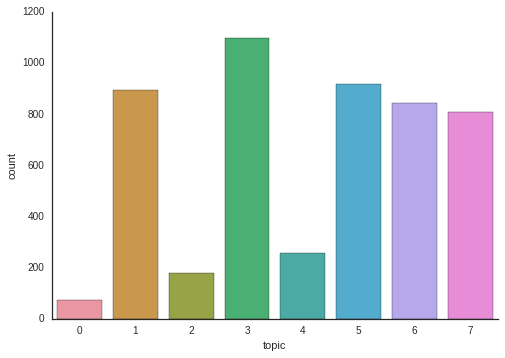

In [25]:
## distribution of providers among topics
ax = sns.countplot(x='topic',data=pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}))
sns.despine()

## Color code distribution over topics by provider_type

In [33]:
by_npi.index = by_npi.index.astype(str)

In [34]:
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(payments.drop_duplicates('npi')[['npi', 'provider_type']]))

In [35]:
## color code for plotting
len(color_codes)

5067

In [36]:
color_codes.head()

,npi,provider_type
0,1003020660,Surgical Oncology
1,1003027582,Radiation Oncology
2,1003027764,Hematology/Oncology
3,1003068347,Radiation Oncology
4,1003073438,Radiation Oncology


In [37]:
topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}),
                              color_codes], axis=1, ignore_index=True).
                    rename(columns={0:'topic',1:'npi',2:'provider_type'}))

topic_per_doc_df.head()
#topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc), fraud_label], axis=1, ignore_index=True).
#                        rename(columns={0:'topic',1:'fraud'}))

,topic,npi,provider_type
0,6,1003020660,Surgical Oncology
1,0,1003027582,Radiation Oncology
2,0,1003027764,Hematology/Oncology
3,5,1003068347,Radiation Oncology
4,3,1003073438,Radiation Oncology


In [38]:
mydf = (topic_per_doc_df.
        groupby(['topic','provider_type']).
        count().
        rename(columns={'npi':'counts'}).
        reset_index())

In [39]:
mydf.head(10)

,topic,provider_type,counts
0,0,Gynecological/Oncology,3
1,0,Hematology/Oncology,2
2,0,Medical Oncology,2
3,0,Radiation Oncology,53
4,0,Surgical Oncology,13
5,1,Gynecological/Oncology,2
6,1,Hematology/Oncology,2
7,1,Medical Oncology,1
8,1,Radiation Oncology,889
9,1,Surgical Oncology,1


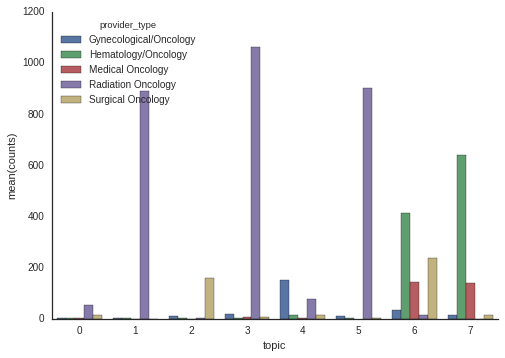

In [40]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
sns.despine()

In [41]:
## plot fractions per provider_type rather than absolute counts across topics

## rescale each of the counts by overall total per fraud group
#mydf.groupby(['provider_type']).transform(lambda x: x.sum()['counts'])
types = list(payments['provider_type'].unique())

for t in types:
    mydf.loc[mydf.provider_type == t, 'counts']  = (mydf.loc[mydf.provider_type == t, 'counts'] / 
                                          float(sum(mydf.loc[mydf.provider_type == t, 'counts'])))

mydf.head()

,topic,provider_type,counts
0,0,Gynecological/Oncology,0.012500
1,0,Hematology/Oncology,0.001854
2,0,Medical Oncology,0.006667
3,0,Radiation Oncology,0.017661
4,0,Surgical Oncology,0.029083


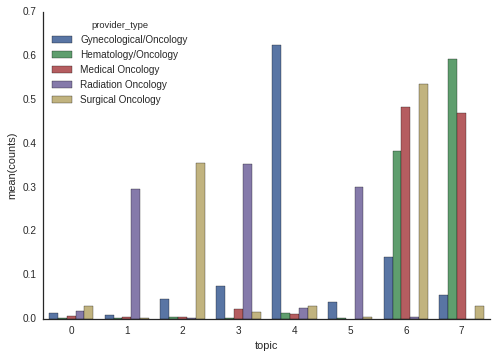

In [42]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
sns.despine()

- Looks like radiation oncology is dominating 3 topics again: 1, 3, and 5.
- Medical Oncology and Hematology/Oncology both co-occur again, this time topics 6, 7.

## Plot doctors in topic space

In [43]:
from sklearn.manifold import TSNE
#from sklearn import preprocessing

In [44]:
topics_per_doc = []

## Get features per doc (probability scores over topics)
for doc in corpus_tfidf:
    topics_per_doc.append(np.array(ldamodel.get_document_topics(doc))[:,1])

by_npi_topics = pd.DataFrame(topics_per_doc)
by_npi_topics.shape

(5067, 8)

In [45]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi_topics.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5067
[t-SNE] Computed conditional probabilities for sample 2000 / 5067
[t-SNE] Computed conditional probabilities for sample 3000 / 5067
[t-SNE] Computed conditional probabilities for sample 4000 / 5067
[t-SNE] Computed conditional probabilities for sample 5000 / 5067
[t-SNE] Computed conditional probabilities for sample 5067 / 5067
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.6992319, gradient norm = 0.0107164
[t-SNE] Iteration 50: error = 1.6178653, gradient norm = 0.0081443
[t-SNE] Iteration 75: error = 1.2457769, gradient norm = 0.0041094
[t-SNE] Iteration 100: error = 1.1576493, gradient norm = 0.0039719
[t-SNE] Error after 100 iterations with early exaggeration: 1.157649
[t-SNE] Iteration 125: error = 1.0113653, gradient norm = 0.0045138
[t-SNE] Iteration 150: error = 0.9675059, gradient norm = 0.0044159
[t-SNE] Iteration 

In [55]:
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df = (pd.concat([X_embedded_df, topic_per_doc_df['provider_type']], axis=1, ignore_index=True)).rename(columns={0:'x', 1:'y', 2:'provider_type'})

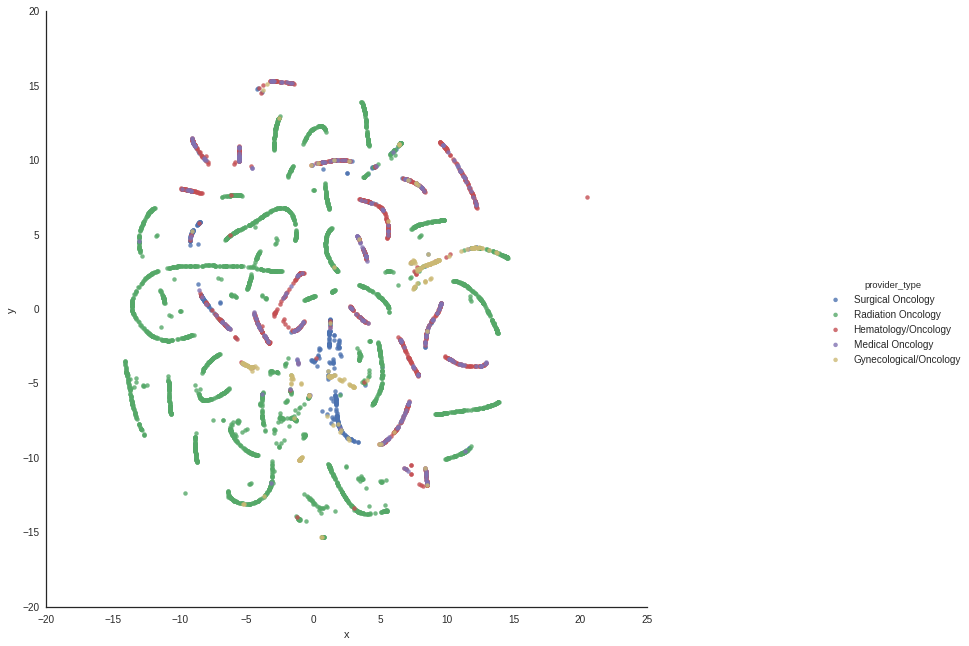

In [77]:
#plt.rcParams['figure.figsize'] = (20.0, 20.0)
#plt.figure(figsize=(8, 6))
plt.rcParams['figure.figsize']=(10,20)
fig = plt.figure(figsize=(10,10))
sns.lmplot(x='x', y='y', data=X_embedded_df, hue='provider_type', fit_reg=False)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.rcParams['figure.figsize'] = (20.0, 20.0)

## tsne on original space

In [78]:
X_embedded0 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5067
[t-SNE] Computed conditional probabilities for sample 2000 / 5067
[t-SNE] Computed conditional probabilities for sample 3000 / 5067
[t-SNE] Computed conditional probabilities for sample 4000 / 5067
[t-SNE] Computed conditional probabilities for sample 5000 / 5067
[t-SNE] Computed conditional probabilities for sample 5067 / 5067
[t-SNE] Mean sigma: 11.787872
[t-SNE] Iteration 25: error = 1.6473386, gradient norm = 0.0107654
[t-SNE] Iteration 50: error = 1.5770032, gradient norm = 0.0067479
[t-SNE] Iteration 75: error = 1.2976243, gradient norm = 0.0025956
[t-SNE] Iteration 100: error = 1.2364761, gradient norm = 0.0021746
[t-SNE] Error after 100 iterations with early exaggeration: 1.236476
[t-SNE] Iteration 125: error = 1.1354302, gradient norm = 0.0017302
[t-SNE] Iteration 150: error = 1.1028618, gradient norm = 0.0016038
[t-SNE] Iteration

In [79]:
X_embedded_df0 = pd.DataFrame(X_embedded0)
X_embedded_df0 = (pd.concat([X_embedded_df0, topic_per_doc_df['provider_type']], axis=1, ignore_index=True)).rename(columns={0:'x', 1:'y', 2:'provider_type'})

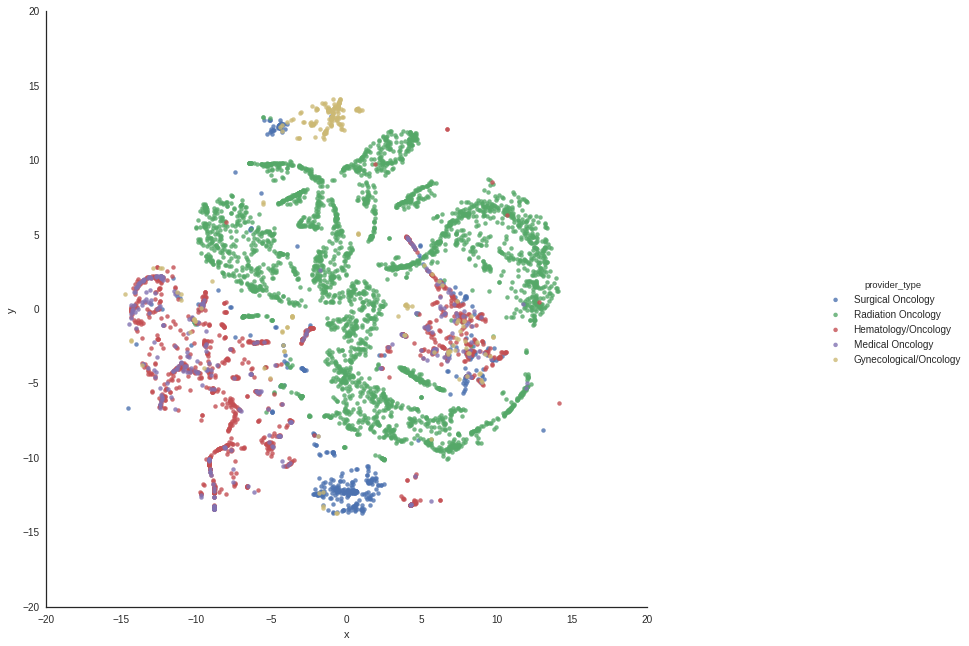

In [80]:
#plt.rcParams['figure.figsize'] = (20.0, 20.0)
#plt.figure(figsize=(8, 6))
plt.rcParams['figure.figsize']=(10,20)
fig = plt.figure(figsize=(10,10))
sns.lmplot(x='x', y='y', data=X_embedded_df0, hue='provider_type', fit_reg=False)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.rcParams['figure.figsize'] = (20.0, 20.0)

- Radiation oncologists clearly cluster together, and are the largest group.  
- LDA collapses the points onto manifolds that are still consistent with their provider_type.
- Surgical oncology is also well-separated out in the original data, but possibly misleadingly grouped with radiation oncology in the topic space.
- In both plots, hematology/oncology and medical oncology are pretty mixed.  Next steps, dive into these 2 groups.